 X-ray sim
In this notebook we generate synthetic X-ray observations from simulated sources using Illustrius TNT-300 and pyxsim 

In [1]:
import os
import sys
import numpy as np
import requests
import json
import datetime
from tqdm import tqdm
import yt

/home/sam/.local/lib/python3.8/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/sam/.config/yt/ytrc is deprecated in favor of /home/sam/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [2]:
def get(path, headers, cutout_datafolder, params=None):
    if 'cutout' in path:
        # If the path is a cutout getter, check if we already have it
        filename = get_saved_file(path, cutout_datafolder)
        if filename != "":
            # We have the file return the name
            return filename

    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json()  # parse json responses automatically

    if 'cutout' in path and 'content-disposition' in r.headers:
        filename = save_cutout(cutout_url=path, content=r.content, datafolder_name=cutout_datafolder)
        return filename  # return the filename string
    return r


def get_and_save_cutouts(subs, headers, cutout_datafolder):
#     cutout_request = {
#         'gas': 'Coordinates,Density,ElectronAbundance,GFM_Metallicity,InternalEnergy,Masses,NeutralHydrogenAbundance,Velocities'}

    for i in tqdm(range(len(subs))):
        try:
            sub = get(subs[i]['url'], headers=headers, cutout_datafolder=cutout_datafolder)
            cutout = get(sub['cutouts']['subhalo'], headers=headers, cutout_datafolder=cutout_datafolder, params=cutout_request)
        except Exception as e:
            print(f"Failed to load number {i}, error:")
            print(e)


def get_cutout_from_sub(sub, headers, cutout_datafolder):
    print("Downloading cutout:", sub['cutouts']['subhalo'])
    cutout_request = {
        'gas': 'Coordinates,Density,ElectronAbundance,GFM_Metallicity,InternalEnergy,Masses,NeutralHydrogenAbundance,Velocities'}
    cutout = get(sub['cutouts']['subhalo'], headers=headers, cutout_datafolder=cutout_datafolder,  params=cutout_request)
    return cutout

def write_dict_to_file(d, path):
    file = open(path, "w")
    json.dump(d, file)
    file.close()


def load_dict_from_file(path):
    file = open(path, 'r')
    d = json.load(file)
    file.close()
    return d

# Since the cutout files are quite large (+- 1gb) we do not want to download them if we already have them
# in order to do this we check

def get_saved_file(cutout_url, datafolder_name):
    reg_filename = 'reg.json'
    filename_dict = {}  # Start with an empty dict
    reg_path = os.path.join(datafolder_name, reg_filename)
    if not os.path.exists(datafolder_name):
        # If the folder does not exist make it and the registry file
        os.makedirs(datafolder_name)
        write_dict_to_file(filename_dict, reg_path)
        return ""

    # The folder exists, load the filenames
    filename_dict = load_dict_from_file(reg_path)
    if cutout_url in filename_dict:
        return filename_dict[cutout_url]
    else:
        return ""


def save_cutout(cutout_url, content, datafolder_name):
    reg_filename = 'reg.json'
    reg_path = os.path.join(datafolder_name, reg_filename)
    # Create a unique filename, use the url as base if possible
    try:
        parts = cutout_url.split('/')
        filename = parts[-6].replace('-', '_') + "_z_" + parts[-4] + "_" + parts[-3] + "_" + parts[-2] + ".hdf5"
        # url = 'http://www.tng-project.org/api/TNG300-1/snapshots/99/subhalos/538308/cutout.hdf5'
        # becomes: TNG300-1_z_99_subhalos_538308.hdf5
    except:
        # The url is not the right format, use the datetime timestamp as name
        d = datetime.datetime.utcnow()
        epoch = datetime.datetime(1970, 1, 1)
        t = (d - epoch).total_seconds()
        filename = str(t).replace(".", "") + ".hdf5"

    # Write the file
    with open(os.path.join(datafolder_name, filename), 'wb') as f:
        f.write(content)

    # Update the reg dict
    filename_dict = load_dict_from_file(reg_path)
    filename_dict[cutout_url] = filename
    write_dict_to_file(filename_dict, reg_path)

    return filename

In [3]:
# Setup working directory
root_dir = os.path.abspath('')
working_dir = os.path.join(root_dir, 'tng_multiple_test/')
if not os.path.exists(working_dir):
    # If the folder does not exist make it
    os.makedirs(working_dir)
    print("Created workingdir:", working_dir)

    # Create the fits dir
    os.makedirs(os.path.join(working_dir, "fits"))

os.chdir(working_dir)
sys.path.append(working_dir)
cutout_datafolder = os.path.join(working_dir, 'cutout_data')

Created workingdir: /home/sam/Documents/ESA/xmm_simulation/other/simput_input/tng_multiple_test/


In [4]:
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"fdfa5784020a1287be0ca6456f1ac0e6"}

In [5]:
print("Getting snaps...")

r = get(baseUrl, headers=headers, cutout_datafolder=cutout_datafolder)
names = [sim['name'] for sim in r['simulations']]

simulation_names = ['TNG300-1'] # ['TNG50-1', 'TNG50-2', 'TNG50-3', 'TNG50-4', 'TNG100-1', 'TNG100-2', 'TNG100-3', 'TNG300-1', 'TNG300-2', 'TNG300-3']
snapshot_nums = [99] # [89, 99]
subs_r = [] #Save the sub results in one list
for name in simulation_names:
    i = names.index(name)
    sim = get(r['simulations'][i]['url'], headers=headers, cutout_datafolder=cutout_datafolder)
    snaps = get(sim['snapshots'], headers=headers, cutout_datafolder=cutout_datafolder)
    
    subs_sim_r = []
    print("Getting subs of", name)
    # There are 100 snapshots, the last one corresponds to z=0
    for z in snapshot_nums:
        print("snapshot num (z):",z)
        snap = get(snaps[z]['url'], headers=headers, cutout_datafolder=cutout_datafolder)

        # request and inspect most massive 100 subhalos that are central (primary_flag = 1)
        # primary_flag = 1 indicates that this is the central (i.e. most massive, or "primary") subhalo of this FoF halo.
        

        subs_sim_z_r = get(snap['subhalos'], headers=headers, cutout_datafolder=cutout_datafolder, params= {'limit':100, 'primary_flag':1, 'order_by':'-mass_gas'}) #'order_by':'-mass_dm'
        subs_sim_r += subs_sim_z_r['results']
        
    subs_r += subs_sim_r
    print(f"Number of subs loaded for {name}",len(subs_sim_r))

print(f"Total subs loaded",len(subs_r))

Getting snaps...
Getting subs of TNG300-1
snapshot num (z): 99
Number of subs loaded for TNG300-1 100
Total subs loaded 100


In [6]:
# subs_r

### Download and load one sub

In [7]:
# Download all the cutouts
# get_and_save_cutouts(subs=[subs_r[0]], headers=headers, cutout_datafolder=cutout_datafolder)
sub_num = 0
sub = get(subs_r[sub_num]['url'], headers=headers, cutout_datafolder=cutout_datafolder)
cutout = get_cutout_from_sub(sub=sub,
                                 headers=headers, cutout_datafolder=cutout_datafolder)  # If the cutout is aldready downloaded it loads it, otherwise it will download and save the cutout
filename = cutout.replace('.hdf5', '')

In [8]:
cutout_path = os.path.join(cutout_datafolder, cutout)
ds = yt.load(cutout_path, default_species_fields="ionized")
for field in ds.derived_field_list:
    print(field)

yt : [INFO     ] 2021-07-12 13:35:11,257 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2021-07-12 13:35:11,335 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2021-07-12 13:35:11,336 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-07-12 13:35:11,337 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-07-12 13:35:11,338 Parameters: domain_right_edge         = [205000. 205000. 205000.]
yt : [INFO     ] 2021-07-12 13:35:11,338 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-07-12 13:35:11,339 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2021-07-12 13:35:11,339 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2021-07-12 13:35:11,340 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2021-07-12 13:35:11,340 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-07-12 13:35:11,340 Parameters: hubble_con

('PartType0', 'Coordinates')
('PartType0', 'Density')
('PartType0', 'ElectronAbundance')
('PartType0', 'GFM_Metallicity')
('PartType0', 'H_nuclei_density')
('PartType0', 'He_nuclei_density')
('PartType0', 'He_p2_number_density')
('PartType0', 'InternalEnergy')
('PartType0', 'Masses')
('PartType0', 'NeutralHydrogenAbundance')
('PartType0', 'Temperature')
('PartType0', 'Velocities')
('PartType0', 'angular_momentum')
('PartType0', 'angular_momentum_magnitude')
('PartType0', 'angular_momentum_x')
('PartType0', 'angular_momentum_y')
('PartType0', 'angular_momentum_z')
('PartType0', 'cylindrical_radius')
('PartType0', 'cylindrical_theta')
('PartType0', 'cylindrical_velocity_theta')
('PartType0', 'cylindrical_velocity_z')
('PartType0', 'cylindrical_z')
('PartType0', 'density')
('PartType0', 'mass')
('PartType0', 'metallicity')
('PartType0', 'ones')
('PartType0', 'particle_angular_momentum')
('PartType0', 'particle_angular_momentum_magnitude')
('PartType0', 'particle_angular_momentum_x')
('Par

yt : [INFO     ] 2021-07-11 03:16:42,870 xlim = 43218.800000 44218.800000
yt : [INFO     ] 2021-07-11 03:16:42,870 ylim = 48313.600000 49313.600000
yt : [INFO     ] 2021-07-11 03:16:42,871 xlim = 43218.800000 44218.800000
yt : [INFO     ] 2021-07-11 03:16:42,872 ylim = 48313.600000 49313.600000
yt : [INFO     ] 2021-07-11 03:16:42,872 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



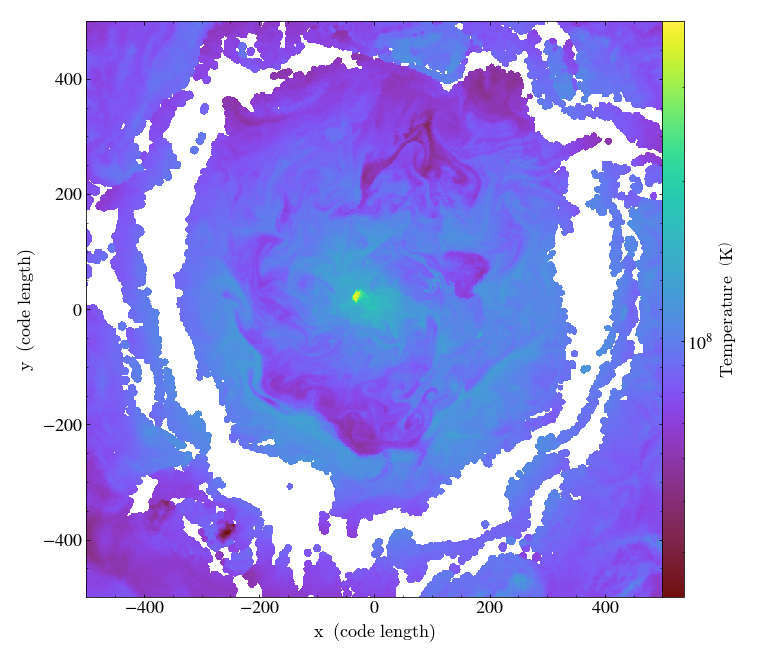

In [9]:
# yt.SlicePlot(ds, 'z', ('gas', 'temperature'), center=(sub['pos_x'], sub['pos_y'], sub['pos_z']), 
#              width=(1000.0, "code_length"))

### Add xray_emissivitiy

In [9]:
# The cutout_to_simput is quite time_consuming therefore we multi-process it
emin = 0.5
emax = 2.0
redshift = 0.05  # The redshift to the object.

# See documentation (https://yt-project.org/doc/reference/api/yt.fields.xray_emission_fields.html?highlight=xray_emission_fields#module-yt.fields.xray_emission_fields)
yt.add_xray_emissivity_field(ds, emin, emax, redshift)#, table_type='apec')

yt : [INFO     ] 2021-07-12 13:35:28,071 Loading emissivity data from ./cloudy_emissivity_v2.h5
yt : [INFO     ] 2021-07-12 13:35:28,087 X-ray emissivity data calculated with Cloudy 13 rc1 on 12/10/2012 by Britton Smith.
yt : [INFO     ] 2021-07-12 13:35:28,088 X-ray 'cloudy' emissivity data version: 2.
yt : [INFO     ] 2021-07-12 13:35:28,214 Adding ('gas','xray_emissivity_0.5_2.0_keV') field.
yt : [INFO     ] 2021-07-12 13:35:28,215 Adding ('gas','xray_luminosity_0.5_2.0_keV') field.
yt : [INFO     ] 2021-07-12 13:35:28,215 Adding ('gas','xray_photon_emissivity_0.5_2.0_keV') field.
yt : [INFO     ] 2021-07-12 13:35:28,215 Adding ('gas','xray_intensity_0.5_2.0_keV') field.
yt : [INFO     ] 2021-07-12 13:35:28,216 Adding ('gas','xray_photon_intensity_0.5_2.0_keV') field.


[('gas', 'xray_emissivity_0.5_2.0_keV'),
 ('gas', 'xray_luminosity_0.5_2.0_keV'),
 ('gas', 'xray_photon_emissivity_0.5_2.0_keV'),
 ('gas', 'xray_intensity_0.5_2.0_keV'),
 ('gas', 'xray_photon_intensity_0.5_2.0_keV')]

In [65]:
for field in ds.derived_field_list:
    print(field)

('PartType0', 'Coordinates')
('PartType0', 'Density')
('PartType0', 'ElectronAbundance')
('PartType0', 'GFM_Metallicity')
('PartType0', 'H_nuclei_density')
('PartType0', 'He_nuclei_density')
('PartType0', 'He_p2_number_density')
('PartType0', 'InternalEnergy')
('PartType0', 'Masses')
('PartType0', 'NeutralHydrogenAbundance')
('PartType0', 'Temperature')
('PartType0', 'Velocities')
('PartType0', 'angular_momentum')
('PartType0', 'angular_momentum_magnitude')
('PartType0', 'angular_momentum_x')
('PartType0', 'angular_momentum_y')
('PartType0', 'angular_momentum_z')
('PartType0', 'cylindrical_radius')
('PartType0', 'cylindrical_theta')
('PartType0', 'cylindrical_velocity_theta')
('PartType0', 'cylindrical_velocity_z')
('PartType0', 'cylindrical_z')
('PartType0', 'density')
('PartType0', 'mass')
('PartType0', 'metallicity')
('PartType0', 'ones')
('PartType0', 'particle_angular_momentum')
('PartType0', 'particle_angular_momentum_magnitude')
('PartType0', 'particle_angular_momentum_x')
('Par

yt : [INFO     ] 2021-07-12 13:35:30,251 xlim = 43218.800000 44218.800000
yt : [INFO     ] 2021-07-12 13:35:30,252 ylim = 48313.600000 49313.600000
yt : [INFO     ] 2021-07-12 13:35:30,253 xlim = 43218.800000 44218.800000
yt : [INFO     ] 2021-07-12 13:35:30,253 ylim = 48313.600000 49313.600000
yt : [INFO     ] 2021-07-12 13:35:30,254 Making a fixed resolution buffer of (('gas', 'xray_photon_emissivity_0.5_2.0_keV')) 800 by 800



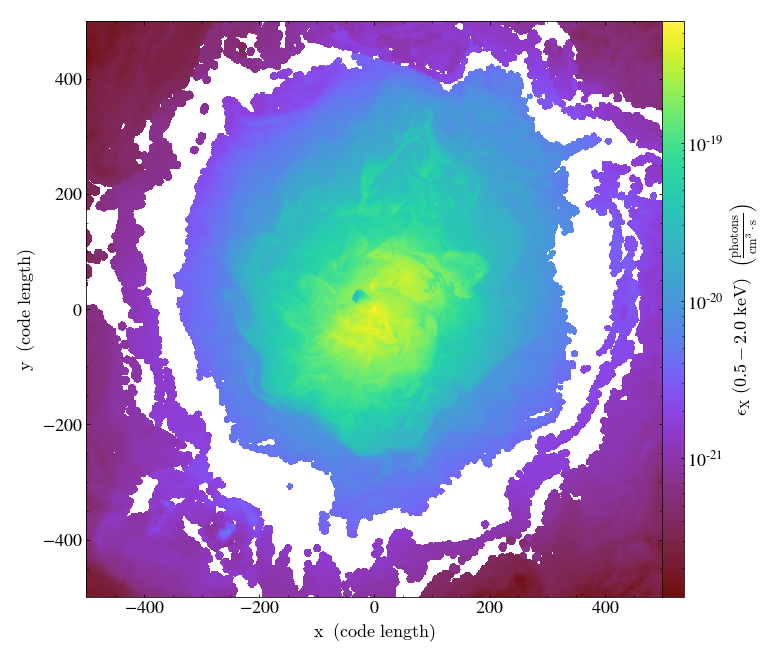

In [10]:
yt.SlicePlot(ds, 'z', ('gas', 'xray_photon_emissivity_0.5_2.0_keV'), center=(sub['pos_x'], sub['pos_y'], sub['pos_z']), 
             width=(1000.0, "code_length"))

In [16]:
# Take the normals from all directions
normals = [[1, 0, 0], [-1, 0, 0], [0, 1, 0], [0, -1, 0], [0, 0, 1], [0, 0, -1]]

normal = normals[0]


p = yt.OffAxisSlicePlot(

#     ds, "x", ("gas", "xray_emissivity_0.5_2_keV"), table_type="apec"
    ds, normal=normal, fields=('gas', 'xray_photon_intensity_0.5_2.0_keV'), center=(sub['pos_x'], sub['pos_y'], sub['pos_z']), 
             width=(800.0, "code_length")
)
p.show()




AttributeError: 'YTSphere' object has no attribute 'coordinates'

In [20]:
yt_fits = yt.FITSSlice(ds, axis='x', fields=('gas', 'xray_photon_intensity_0.5_2.0_keV'),
                                       center=(sub['pos_x'], sub['pos_y'], sub['pos_z']),
                                       width=(1000, "code_length"), image_res=1000)
    
yt_fits.writeto(filename + "_sliceplot.fits", overwrite=True)

yt : [INFO     ] 2021-07-12 13:44:03,925 Making a FITS image of field xray_photon_intensity_0.5_2.0_keV


yt : [INFO     ] 2021-07-11 15:30:54,059 xlim = 43218.800000 44218.800000
yt : [INFO     ] 2021-07-11 15:30:54,060 ylim = 48313.600000 49313.600000
yt : [INFO     ] 2021-07-11 15:30:54,061 xlim = 43218.800000 44218.800000
yt : [INFO     ] 2021-07-11 15:30:54,061 ylim = 48313.600000 49313.600000
yt : [INFO     ] 2021-07-11 15:30:54,062 Making a fixed resolution buffer of (('gas', 'xray_photon_intensity_0.5_2.0_keV')) 800 by 800



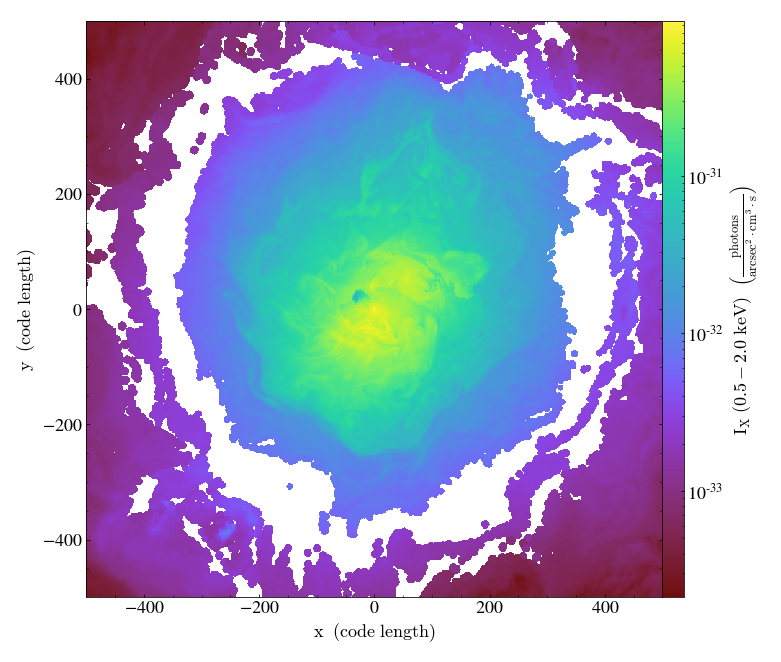

In [81]:
yt.SlicePlot(ds, 'z', ('gas', 'xray_photon_intensity_0.5_2.0_keV'), center=(sub['pos_x'], sub['pos_y'], sub['pos_z']), 
             width=(1000.0, "code_length"))

yt : [INFO     ] 2021-07-11 03:35:08,805 xlim = 43218.800000 44218.800000
yt : [INFO     ] 2021-07-11 03:35:08,805 ylim = 48313.600000 49313.600000
yt : [INFO     ] 2021-07-11 03:35:08,806 xlim = 43218.800000 44218.800000
yt : [INFO     ] 2021-07-11 03:35:08,806 ylim = 48313.600000 49313.600000
yt : [INFO     ] 2021-07-11 03:35:08,807 Making a fixed resolution buffer of (('gas', 'xray_emissivity_0.5_2.0_keV')) 800 by 800



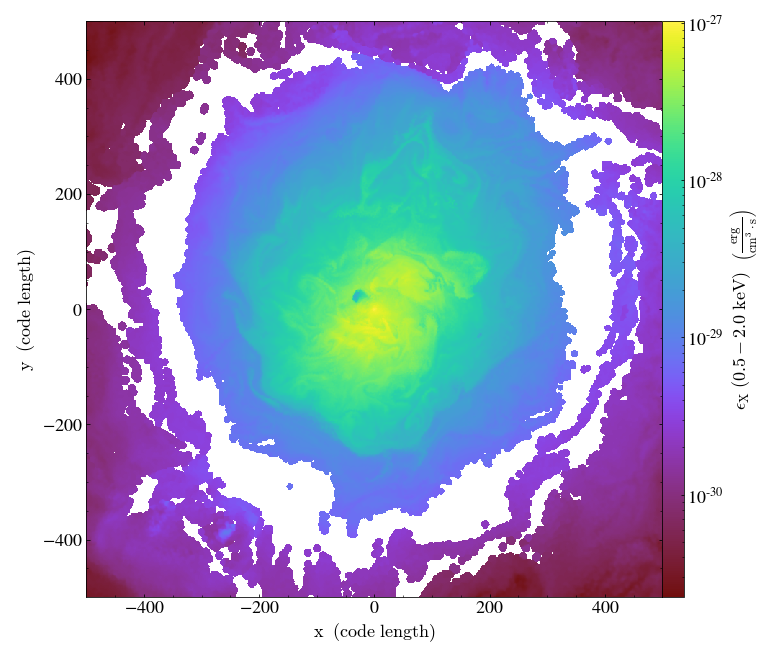

In [53]:
yt.SlicePlot(ds, 'z', ('gas', 'xray_emissivity_0.5_2.0_keV'), center=(sub['pos_x'], sub['pos_y'], sub['pos_z']), 
             width=(1000.0, "code_length"))

yt : [INFO     ] 2021-07-11 03:35:26,416 xlim = 43218.800000 44218.800000
yt : [INFO     ] 2021-07-11 03:35:26,417 ylim = 48313.600000 49313.600000
yt : [INFO     ] 2021-07-11 03:35:26,417 xlim = 43218.800000 44218.800000
yt : [INFO     ] 2021-07-11 03:35:26,418 ylim = 48313.600000 49313.600000
yt : [INFO     ] 2021-07-11 03:35:26,419 Making a fixed resolution buffer of (('gas', 'xray_luminosity_0.5_2.0_keV')) 800 by 800



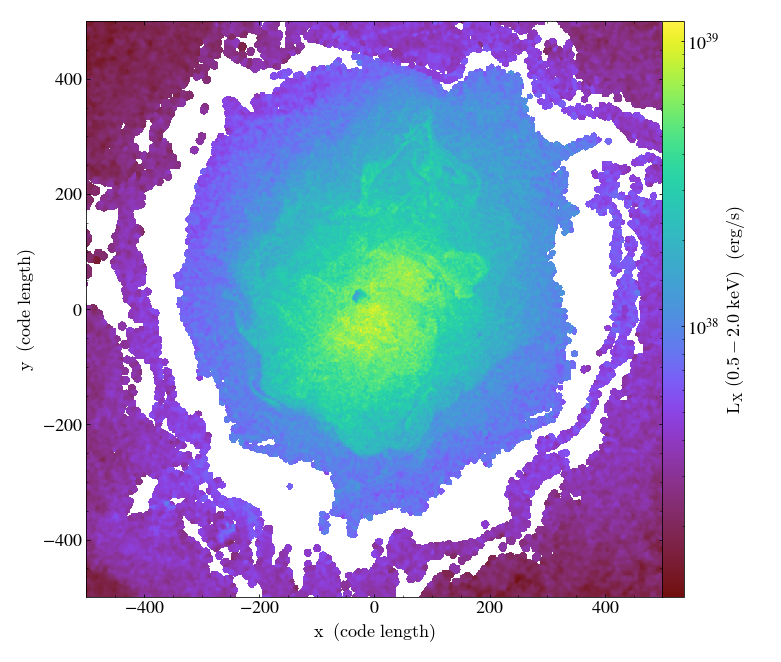

In [54]:
yt.SlicePlot(ds, 'z', ('gas', 'xray_luminosity_0.5_2.0_keV'), center=(sub['pos_x'], sub['pos_y'], sub['pos_z']), 
             width=(1000.0, "code_length"))

yt : [INFO     ] 2021-07-12 02:22:40,846 xlim = 43218.800000 44218.800000
yt : [INFO     ] 2021-07-12 02:22:40,846 ylim = 48313.600000 49313.600000
yt : [INFO     ] 2021-07-12 02:22:40,847 xlim = 43218.800000 44218.800000
yt : [INFO     ] 2021-07-12 02:22:40,848 ylim = 48313.600000 49313.600000
yt : [INFO     ] 2021-07-12 02:22:40,848 Making a fixed resolution buffer of (('gas', 'xray_photon_emissivity_0.5_2.0_keV')) 800 by 800



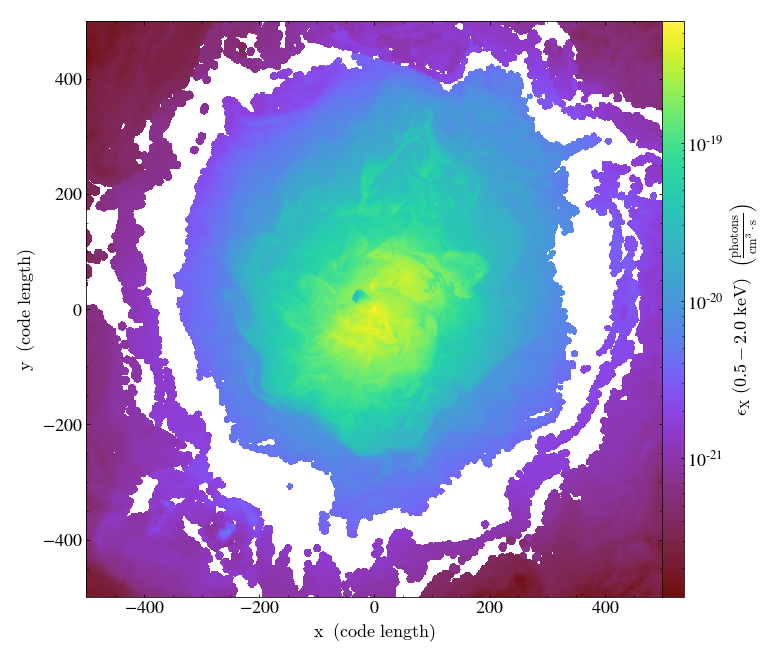

In [108]:
yt.SlicePlot(ds, 'z', ('gas', 'xray_photon_emissivity_0.5_2.0_keV'), center=(sub['pos_x'], sub['pos_y'], sub['pos_z']), 
             width=(1000.0, "code_length"))

yt : [INFO     ] 2021-07-12 02:20:00,087 xlim = 41718.800000 45718.800000
yt : [INFO     ] 2021-07-12 02:20:00,088 ylim = 46813.600000 50813.600000
yt : [INFO     ] 2021-07-12 02:20:00,089 xlim = 41718.800000 45718.800000
yt : [INFO     ] 2021-07-12 02:20:00,090 ylim = 46813.600000 50813.600000
yt : [INFO     ] 2021-07-12 02:20:00,101 Making a fixed resolution buffer of (('gas', 'xray_photon_intensity_0.5_2.0_keV')) 800 by 800
yt : [WARNING  ] 2021-07-12 02:20:28,323 Plotting ('gas', 'xray_photon_intensity_0.5_2.0_keV'): Wide range and zeros.
yt : [WARNING  ] 2021-07-12 02:20:28,323 Switching to symlog colorbar scaling.



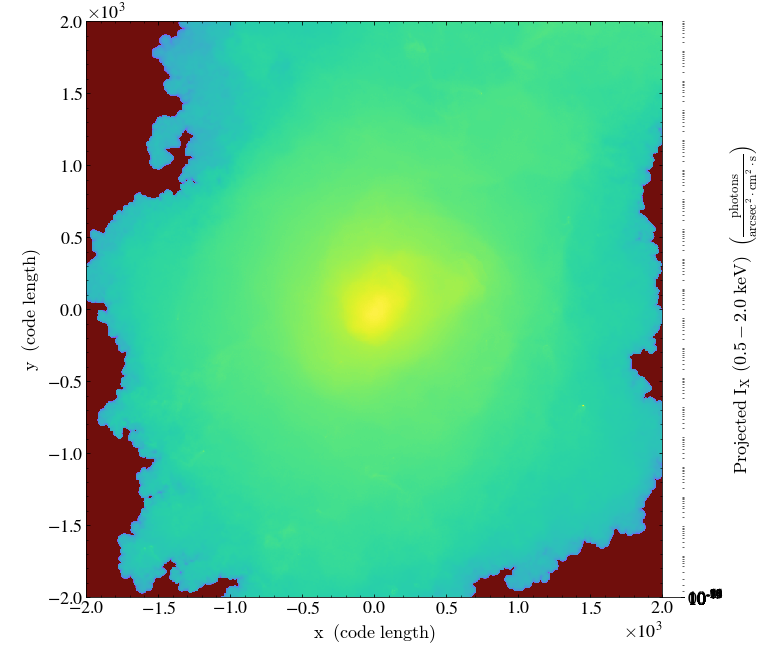

In [105]:
p = yt.ProjectionPlot(

#     ds, "x", ("gas", "xray_emissivity_0.5_2_keV"), table_type="apec"
    ds, 'z', ('gas', 'xray_photon_intensity_0.5_2.0_keV'), center=(sub['pos_x'], sub['pos_y'], sub['pos_z']), 
             width=(4000.0, "code_length")
)
p.show()

yt : [INFO     ] 2021-07-12 11:16:48,276 xlim = -400.000000 400.000000
yt : [INFO     ] 2021-07-12 11:16:48,277 ylim = -400.000000 400.000000
yt : [INFO     ] 2021-07-12 11:16:48,278 zlim = -102500.000000 102500.000000
yt : [INFO     ] 2021-07-12 11:16:48,279 Making a fixed resolution buffer of (('gas', 'xray_photon_intensity_0.5_2.0_keV')) 800 by 800



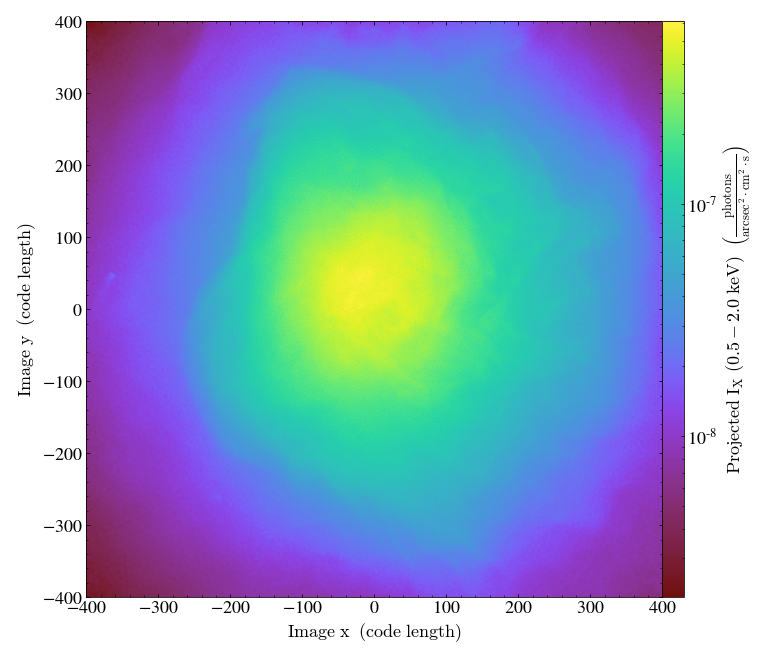

yt : [INFO     ] 2021-07-12 11:17:25,192 xlim = -400.000000 400.000000
yt : [INFO     ] 2021-07-12 11:17:25,193 ylim = -400.000000 400.000000
yt : [INFO     ] 2021-07-12 11:17:25,193 zlim = -102500.000000 102500.000000
yt : [INFO     ] 2021-07-12 11:17:25,194 Making a fixed resolution buffer of (('gas', 'xray_photon_intensity_0.5_2.0_keV')) 800 by 800



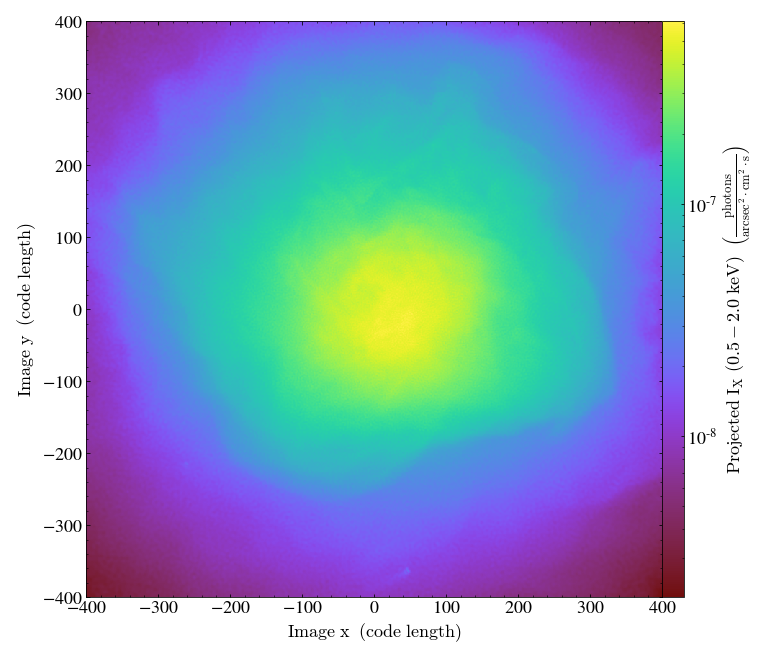

yt : [INFO     ] 2021-07-12 11:18:01,451 xlim = -400.000000 400.000000
yt : [INFO     ] 2021-07-12 11:18:01,451 ylim = -400.000000 400.000000
yt : [INFO     ] 2021-07-12 11:18:01,452 zlim = -102500.000000 102500.000000
yt : [INFO     ] 2021-07-12 11:18:01,452 Making a fixed resolution buffer of (('gas', 'xray_photon_intensity_0.5_2.0_keV')) 800 by 800



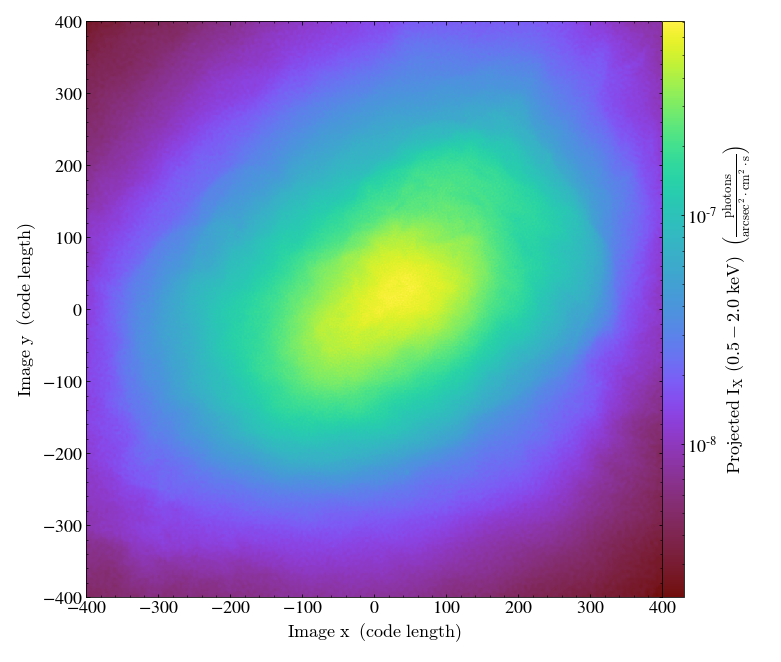

yt : [INFO     ] 2021-07-12 11:18:37,935 xlim = -400.000000 400.000000
yt : [INFO     ] 2021-07-12 11:18:37,936 ylim = -400.000000 400.000000
yt : [INFO     ] 2021-07-12 11:18:37,936 zlim = -102500.000000 102500.000000
yt : [INFO     ] 2021-07-12 11:18:37,937 Making a fixed resolution buffer of (('gas', 'xray_photon_intensity_0.5_2.0_keV')) 800 by 800



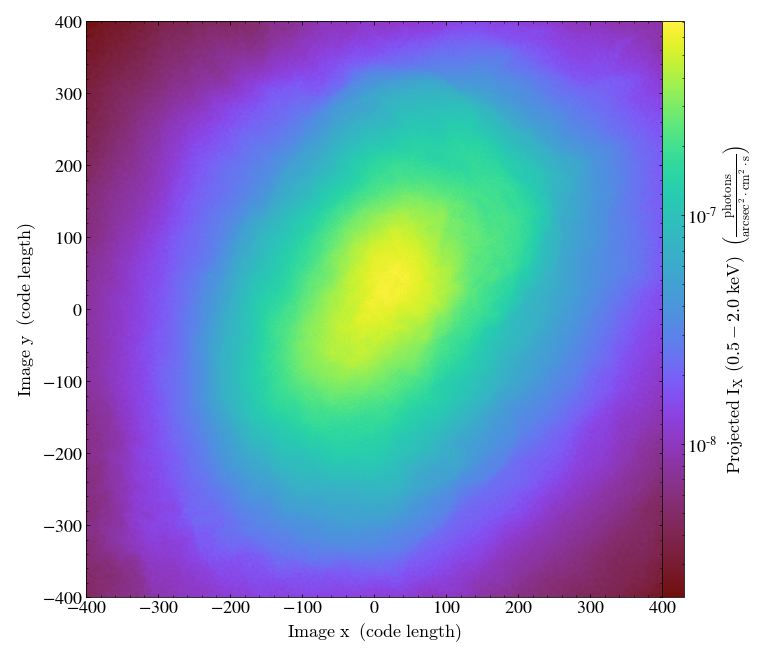

yt : [INFO     ] 2021-07-12 11:19:18,172 xlim = -400.000000 400.000000
yt : [INFO     ] 2021-07-12 11:19:18,173 ylim = -400.000000 400.000000
yt : [INFO     ] 2021-07-12 11:19:18,173 zlim = -102500.000000 102500.000000
yt : [INFO     ] 2021-07-12 11:19:18,174 Making a fixed resolution buffer of (('gas', 'xray_photon_intensity_0.5_2.0_keV')) 800 by 800



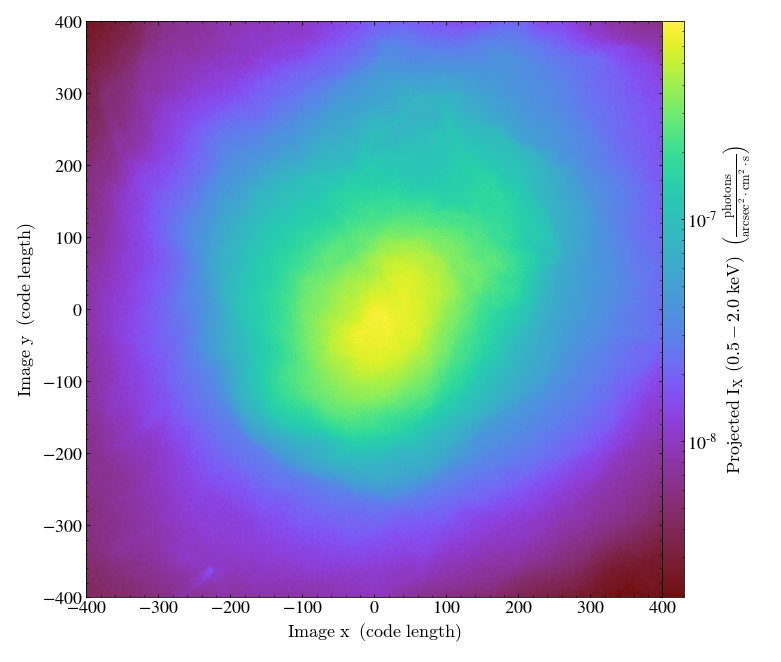

yt : [INFO     ] 2021-07-12 11:19:56,755 xlim = -400.000000 400.000000
yt : [INFO     ] 2021-07-12 11:19:56,755 ylim = -400.000000 400.000000
yt : [INFO     ] 2021-07-12 11:19:56,756 zlim = -102500.000000 102500.000000
yt : [INFO     ] 2021-07-12 11:19:56,757 Making a fixed resolution buffer of (('gas', 'xray_photon_intensity_0.5_2.0_keV')) 800 by 800



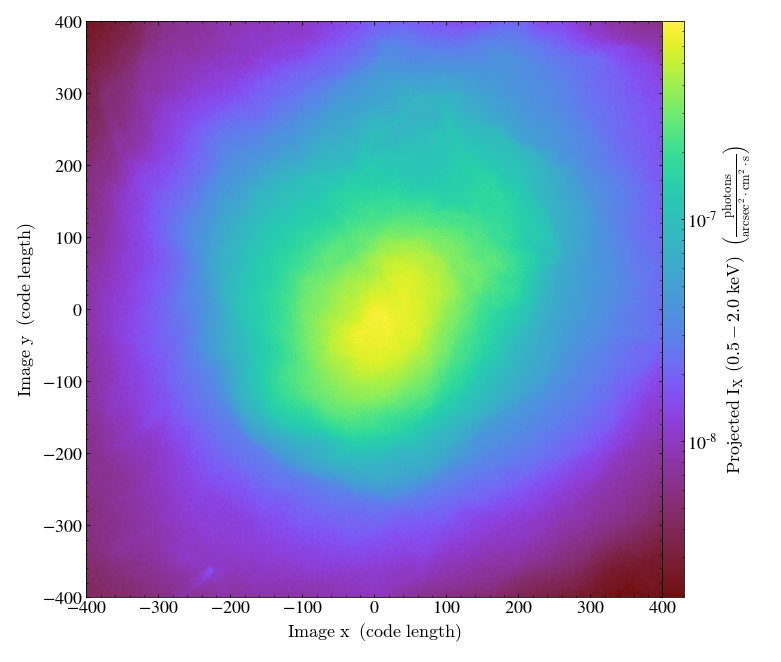

In [114]:
# Take the normals from all directions
normals = [[1, 0, 0], [-1, 0, 0], [0, 1, 0], [0, -1, 0], [0, 0, 1], [0, 0, -1]]

for normal in normals:
    p = yt.OffAxisProjectionPlot(

    #     ds, "x", ("gas", "xray_emissivity_0.5_2_keV"), table_type="apec"
        ds, normal=normal, fields=('gas', 'xray_photon_intensity_0.5_2.0_keV'), center=(sub['pos_x'], sub['pos_y'], sub['pos_z']), 
                 width=(800.0, "code_length")
    )
    p.show()


In [116]:
def make_projection_plot(ds, filename, width, image_res=2048):
    prj_fits = yt.FITSOffAxisProjection(ds, [0,0,1], ('gas', 'xray_photon_intensity_0.5_2.0_keV'), center=(sub['pos_x'], sub['pos_y'], sub['pos_z']), 
             width=(width, "code_length"), image_res=image_res)
#     print(prj_fits['xray_photon_intensity_0.5_2.0_keV'].header)
#     print(prj_fits['xray_photon_intensity_0.5_2.0_keV'].data)
    prj_fits.writeto(filename + "_" + str(width) + "_width" + "_projplot.fits", overwrite=True)

In [117]:
make_projection_plot(ds=ds, filename=filename, width=2000, image_res=2048)

yt : [INFO     ] 2021-07-12 11:37:11,944 Making a FITS image of field xray_photon_intensity_0.5_2.0_keV


In [100]:
make_projection_plot(ds=ds, filename=filename, width=4000, image_res=2048)

yt : [INFO     ] 2021-07-11 15:53:38,612 Making a fixed resolution buffer of (('gas', 'xray_photon_intensity_0.5_2.0_keV')) 2048 by 2048
yt : [INFO     ] 2021-07-11 15:54:50,310 Making a FITS image of field xray_photon_intensity_0.5_2.0_keV


In [101]:
make_projection_plot(ds=ds, filename=filename, width=4000, image_res=4048)

yt : [INFO     ] 2021-07-11 15:56:19,490 Making a fixed resolution buffer of (('gas', 'xray_photon_intensity_0.5_2.0_keV')) 4048 by 4048
yt : [INFO     ] 2021-07-11 15:59:22,670 Making a FITS image of field xray_photon_intensity_0.5_2.0_keV


In [115]:
width = 1000
prj_fits = yt.FITSProjection(ds, [1,0,0], ('gas', 'xray_photon_intensity_0.5_2.0_keV'), center=(sub['pos_x'], sub['pos_y'], sub['pos_z']), 
             width=(1000.0, "code_length"), image_res=2048)
print(prj_fits['xray_photon_intensity_0.5_2.0_keV'].header)
print(prj_fits['xray_photon_intensity_0.5_2.0_keV'].data)
prj_fits.writeto(filename + "_" + str(width) + "_width " + "_projplot.fits", overwrite=True)

TypeError: unhashable type: 'list'

In [86]:


# length_unit defaults to that from the dataset
# image_res defaults to 512
slc_fits = yt.FITSSlice(ds, 'z', ('gas', 'xray_photon_emissivity_0.5_2.0_keV'), center=(sub['pos_x'], sub['pos_y'], sub['pos_z']), 
             width=(600.0, "code_length"), image_res=2048)
print(slc_fits['XRAY_PHOTON_EMISSIVITY_0.5_2.0_KEV'].header)
print(slc_fits['XRAY_PHOTON_EMISSIVITY_0.5_2.0_KEV'].data)
slc_fits.writeto(filename + "_sliceplot.fits", overwrite=True)

yt : [INFO     ] 2021-07-11 15:37:35,444 Making a fixed resolution buffer of (('gas', 'xray_photon_emissivity_0.5_2.0_keV')) 2048 by 2048
yt : [INFO     ] 2021-07-11 15:39:00,035 Making a FITS image of field xray_photon_emissivity_0.5_2.0_keV


SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 2048                                                  NAXIS2  =                 2048                                                  EXTEND  =                    T                                                  EXTNAME = 'XRAY_PHOTON_EMISSIVITY_0.5_2.0_KEV' / extension name                 BTYPE   = 'xray_photon_emissivity_0.5_2.0_keV'                                  BUNIT   = 'photons/(cm**3*s)'                                                   LUNIT   =                  1.0 / [kpc]                                          TUNIT   = 4.55517862415116E+16 / [s]                                            MUNIT   = 2.93622674933569E+43 / [g]                                            VUNIT   =    99999.99999999997 / [cm/s] 

In [ ]:
sp = ds.sphere((sub['pos_x'], sub['pos_y'], sub['pos_z']), (1000.0, "code_length"))

In [62]:
import h5py
filename = "cloudy_emissivity_v2.h5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    keys = list(f.keys())
    
    for key in keys:
        # Get the data
        data = list(f[key])
        print("Key: ", key)
        print(data)

Keys: <KeysViewHDF5 ['E', 'emissivity_metals', 'emissivity_primordial', 'log_T', 'log_nH']>
Key:  E
[0.1, 0.10471285480508996, 0.1096478196143185, 0.1148153621496883, 0.12022644346174129, 0.12589254117941673, 0.1318256738556407, 0.1380384264602885, 0.14454397707459277, 0.1513561248436208, 0.15848931924611134, 0.16595869074375605, 0.17378008287493754, 0.18197008586099836, 0.19054607179632474, 0.19952623149688797, 0.20892961308540398, 0.2187761623949553, 0.2290867652767773, 0.23988329190194904, 0.251188643150958, 0.26302679918953814, 0.2754228703338166, 0.28840315031266056, 0.3019951720402016, 0.31622776601683794, 0.3311311214825911, 0.34673685045253166, 0.3630780547701014, 0.38018939632056115, 0.3981071705534972, 0.4168693834703354, 0.436515832240166, 0.4570881896148751, 0.4786300923226384, 0.5011872336272724, 0.5248074602497725, 0.5495408738576245, 0.5754399373371569, 0.6025595860743578, 0.6309573444801934, 0.6606934480075961, 0.6918309709189364, 0.72443596007499, 0.7585775750291838, 0